In [1]:
import tensorflow as tf
import tensorflow.keras as keras

x = tf.ones(shape=(2,1))
print(x)

2021-09-21 10:48:50.167279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


2021-09-21 10:48:51.017804: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 10:48:51.018283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-21 10:48:51.041724: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-09-21 10:48:51.041741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: alex-Z390-UD
2021-09-21 10:48:51.041746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: alex-Z390-UD
2021-09-21 10:48:51.041790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2021-09-21 10:48:51.041804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
2021-09-21 

In [2]:
x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [3]:
x = tf.random.normal(shape=(5,1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.1908994 ]
 [-0.05346572]
 [-1.0042818 ]
 [ 2.1867902 ]
 [ 2.0839155 ]], shape=(5, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3,1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.34655976]
 [0.16402769]
 [0.41883838]], shape=(3, 1), dtype=float32)


tensorflow tensors are not assignable!!

In [5]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.28960317],
       [ 1.8000959 ],
       [ 0.48374325]], dtype=float32)>


In [6]:
v.assign(tf.ones((3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>


In [7]:
v[0, 0].assign(3.)
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


In [8]:
v.assign_add(tf.ones((3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>


In [9]:
a = tf.ones((2,2))
b = tf.square(a) # square
c = tf.sqrt(a) # square root
d = b + c # element-wise addition
e = tf.matmul(a,b) # product of two tensors
f = a * b # element-wise multiplication

### GradientTape

In [10]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [11]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


### using nested gradient tapes to compute second-order gradients

The gradient of the position of an object with regard to time is the spped of that object, and the second-order gradient is its acceleration.

In [12]:
time = tf.Variable(2.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    speed = inner_tape.gradient(position,time)
acceleration = outer_tape.gradient(speed, time)

print(f'speed: {speed} acceleration: {acceleration}')

speed: 19.600000381469727 acceleration: 9.800000190734863


## a linear classifier in pure TensorFlow

In [13]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)

In [14]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype='float32'),
                     np.ones((num_samples_per_class, 1), dtype='float32')))

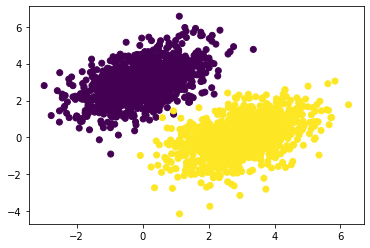

In [15]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets)
plt.show()

now we can learn a linear classifier that can seperate these two blobs.

prediction = W * input + b

In [16]:
input_dim = 2 # inputs are 2d points
output_dim = 1

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

#### forward pass

prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b

In [17]:
def model(inputs):
    return tf.matmul(inputs, W) + b

#### mean squared error loss function

In [18]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [19]:
def training_step(inputs, targets, learning_rate = 0.1):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [20]:
for step in range(25):
    loss = training_step(inputs, targets)
    print('loss at step %d: %.4f' % (step, loss))

loss at step 0: 0.4353
loss at step 1: 0.1398
loss at step 2: 0.1009
loss at step 3: 0.0911
loss at step 4: 0.0851
loss at step 5: 0.0798
loss at step 6: 0.0751
loss at step 7: 0.0708
loss at step 8: 0.0669
loss at step 9: 0.0633
loss at step 10: 0.0600
loss at step 11: 0.0570
loss at step 12: 0.0543
loss at step 13: 0.0518
loss at step 14: 0.0495
loss at step 15: 0.0475
loss at step 16: 0.0456
loss at step 17: 0.0439
loss at step 18: 0.0423
loss at step 19: 0.0408
loss at step 20: 0.0395
loss at step 21: 0.0383
loss at step 22: 0.0372
loss at step 23: 0.0362
loss at step 24: 0.0353


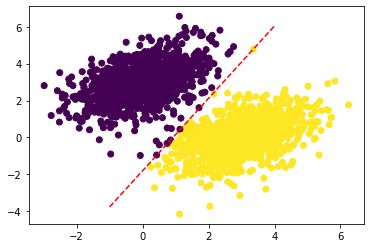

In [21]:
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]
predictions = model(inputs)

plt.plot(x, y, '--r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions > 0.5)
plt.show()

### visualize the learning process

In [29]:
import imageio
import os

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

filenames = []
for step in range(75):
    loss = training_step(inputs, targets)

    x = np.linspace(-1, 4, 100)
    y = - W[0] / W[1] * x + (0.5 - b) / W[1]
    predictions = model(inputs)
    
    plt.plot(x, y, '--r')
    plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions > 0.5)
    plt.ylim([-5, 7])
    # create file name and append it to a list
    filename = f'{step}.png'
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()
        
# build gif 
with imageio.get_writer('linear_classifier.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)

![SegmentLocal](linear_classifier.gif "segment")